In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame
np.random.seed(42)
import autosklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# 对数据取对数
def log_money(df, column):
    df['log_money'] = np.log(df[column])
    return df

# 对取对数的数据还原
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

# 计算有多少比例的数据误差在per之内
def calc_with_err_per(pre_list_svr,true_list_svr,per=0.2):
    numb=0
    for i in np.arange(len(true_list_svr)):
        errorp=abs(pre_list_svr[i]-true_list_svr[i])/true_list_svr[i]
        if errorp<=per:
            numb=numb+1
        else:
            continue
    Percentageratio=float(numb)/len(true_list_svr)
    return Percentageratio,per

In [4]:
# 导入真实数据（经过累加和取对数，没有处理异常值），用于和预测集作对比
data = pd.read_csv('data/original_log_3876.csv', parse_dates = True, index_col=0)
data = data[20:]
data.head()

,log_money
data,
2014-01-21,14.057594
2014-01-22,14.651242
2014-01-23,14.508908
2014-01-24,14.267159
2014-01-25,13.716022


In [5]:
# 导入之前清理完成的数据
reframed = pd.read_csv('data/bank_after_clean_20_3876.csv', parse_dates = True, index_col=0)
reframed.head()

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,6,1,0,0,0,13.524356,13.856365,13.811603,13.064734,12.901717,...,13.076738,14.137884,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594
2014-01-22,5,2,0,0,0,13.856365,13.811603,13.064734,12.901717,14.137884,...,14.137884,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567
2014-01-23,6,3,0,0,0,13.811603,13.064734,12.901717,14.137884,13.361380,...,13.582443,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692
2014-01-24,6,4,0,0,0,13.064734,12.901717,14.137884,13.361380,14.129372,...,14.394200,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692,14.267159
2014-01-25,6,5,1,0,0,12.901717,14.137884,13.361380,14.129372,13.049578,...,13.457692,14.065101,13.535532,13.037241,14.363863,14.057594,14.384567,13.457692,14.267159,13.716022


In [6]:
# 得到np.array格式的数据（不包括index:data）
values = reframed.values
# 划分训练集和测试集
train = values[:805, :]
test = values[805:, :]
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:,:-1], test[:, -1]

In [7]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((805, 25), (276, 25), (805,), (276,))

autosklearn 自动调参

In [8]:
# from autosklearn.regression import AutoSklearnRegressor
# automl = AutoSklearnRegressor()
# automl.fit(train_X, train_y)
# y_hat = automl.predict(test_X)

使用SVR模型预测

In [9]:
from sklearn.svm import SVR

In [10]:
clf_svr = SVR(kernel='linear', C = 1)
clf_svr.fit(train_X, train_y.ravel())
pre_next = clf_svr.predict(test_X[0].reshape(1, -1))
prediction_svr = clf_svr.predict(test_X)
pre_list_svr = prediction_svr.tolist()
true_list_svr = data.values[805:].flatten().tolist()

还原数据，计算准确率

In [11]:
restore_pre = restore_log(pre_list_svr)

restore_true = restore_log(true_list_svr)

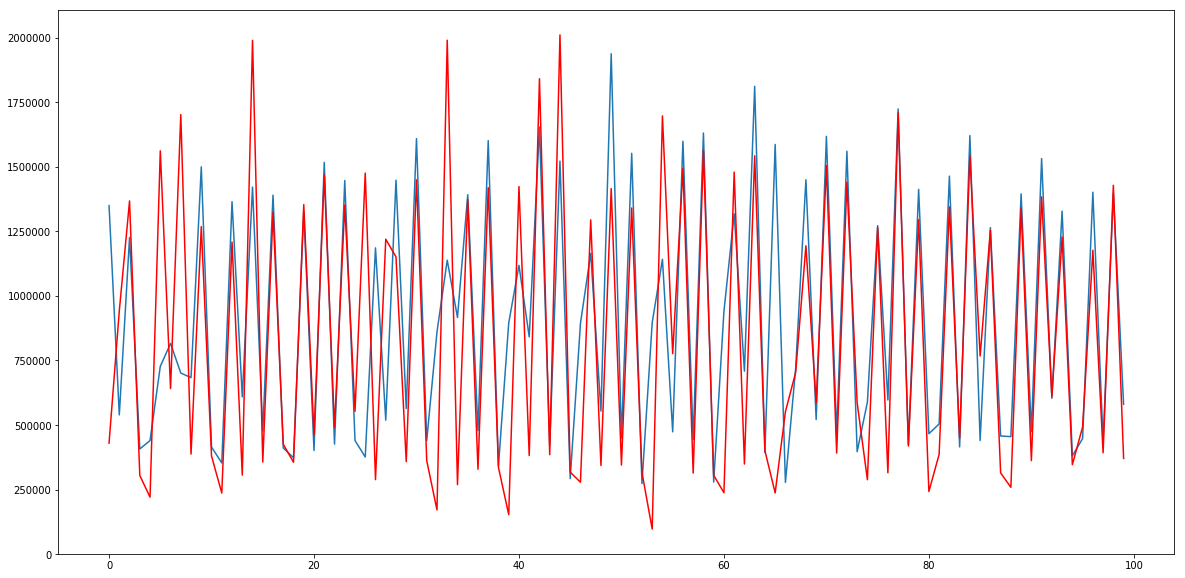

In [12]:
plt.plot(restore_pre[:100])
plt.plot(restore_true[:100], color='red')
plt.show()

In [13]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,restore_true))))
print('误差：%.2f%%'%float((error/len(true_list_svr))*100))

误差：54.31%


In [14]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(pre_list_svr)):
    if pre_list_svr[i] > true_list_svr[i]:
        count += 1
ratio = count/len(pre_list_svr)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：68.12%


In [15]:
Percentageratio,per = calc_with_err_per(pre_list_svr,true_list_svr,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 50.00% 的数据误差在 20.00% 之内


使用处理异常值之后的数据作为原始数据，计算准确率

In [16]:
# # 导入真实数据（经过累加和取对数，没有处理异常值），用于和预测集作对比
# data = pd.read_csv('data/original_log_no_abnorm_7529.csv', parse_dates = True, index_col=0)
# data = data[20:]
# data.head()

# true_list_svr = data.values[805:].flatten().tolist()

# plt.plot(restore_pre[:100])
# plt.plot(true_list_svr[:100], color='red')
# plt.show()

# # 计算误差
# error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,true_list_svr))))
# print('误差：%.2f%%'%float((error/len(true_list_svr))*100))

# # 覆盖率计算，预测值大于真实值
# count = 0
# for i in range(len(pre_list_svr)):
#     if pre_list_svr[i] > true_list_svr[i]:
#         count += 1
# ratio = count/len(pre_list_svr)
# print("覆盖率为：%.2f%%"% (ratio*100))

# Percentageratio,per = calc_with_err_per(pre_list_svr,true_list_svr,0.2)
# print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

使用SVR模型滚动预测

In [17]:
pre_list_svr = []
for i in range(len(test_X)):
    clf_svr = SVR(kernel='linear', C = 1)
    clf_svr.fit(train_X, train_y.ravel())
    pre_next = float(clf_svr.predict(test_X[0].reshape(1, -1)))
    pre_list_svr.append(pre_next)
    train_X = np.r_[train_X ,test_X[0].reshape(1, -1)]
    test_X = test_X[1:,:]
    train_y = np.r_[train_y ,test_y[0]]
    test_y = test_y[1:]
#     print(train_X.shape, test_X.shape, train_y.shape, test_y.shape, pre_next)

In [18]:
len(pre_list_svr),len(true_list_svr)

(276, 276)

In [19]:
def restore_log(num_list):
    for i in range(len(num_list)):
        num_list[i] = np.exp(num_list[i])
    return num_list

restore_pre = restore_log(pre_list_svr)

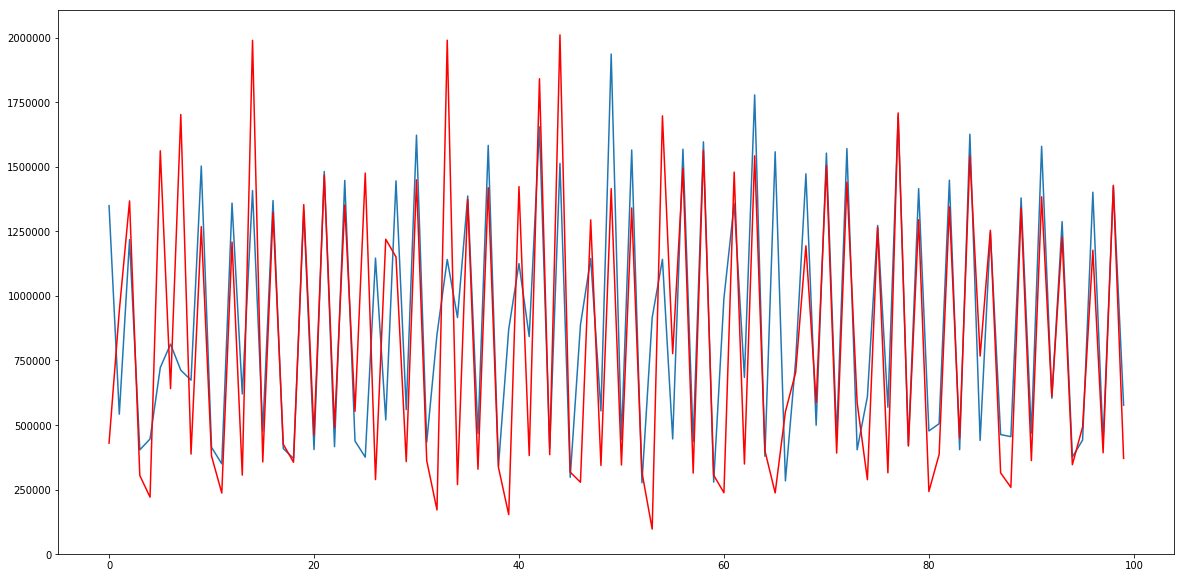

In [20]:
plt.plot(restore_pre[:100])
plt.plot(restore_true[:100], color='red')
plt.show()

In [21]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_list_svr,true_list_svr))))
# error = sum(list(map(lambda x: x[0]-x[1], zip(pre_list,true_list))))
print('误差：%.2f%%'%float((error/len(true_list_svr))*100))

误差：53.27%


In [22]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(pre_list_svr)):
    if pre_list_svr[i] > true_list_svr[i]:
        count += 1
ratio = count/len(pre_list_svr)
print("覆盖率为： %.2f"% ratio)

覆盖率为： 0.66


In [23]:
# 计算有多少比例的数据误差在per之内
Percentageratio,per = calc_with_err_per(pre_list_svr,true_list_svr,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 52.17% 的数据误差在 20.00% 之内


使用处理异常值之后的数据作为原始数据，计算准确率

In [24]:
# 导入真实数据（经过累加和取对数，处理过异常值），用于和预测集作对比
data = pd.read_csv('data/original_log_no_abnorm_3876.csv', parse_dates = True, index_col=0)
data = data[20:]
data.head()

,money
data,
2014-01-21,1273900.0
2014-01-22,1766600.0
2014-01-23,699200.0
2014-01-24,1570900.0
2014-01-25,905300.0


In [25]:
true_list_svr = data.values[805:].flatten().tolist()

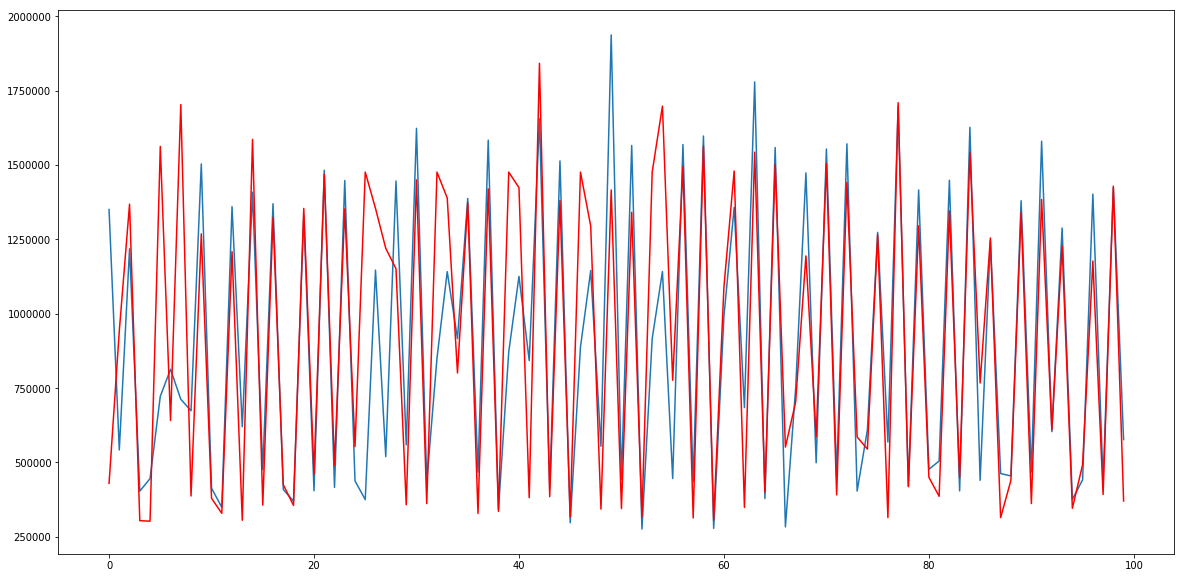

In [26]:
plt.plot(restore_pre[:100])
plt.plot(true_list_svr[:100], color='red')
plt.show()

In [27]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre,true_list_svr))))
print('误差：%.2f%%'%float((error/len(true_list_svr))*100))

误差：22.17%


In [28]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(pre_list_svr)):
    if pre_list_svr[i] > true_list_svr[i]:
        count += 1
ratio = count/len(pre_list_svr)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：61.96%


In [29]:
Percentageratio,per = calc_with_err_per(pre_list_svr,true_list_svr,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 68.48% 的数据误差在 20.00% 之内
